In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import islets
from copy import copy, deepcopy
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import LogNorm
from matplotlib import patches

def get_means_and_variances(regions, ts, Nt = 100):
    s,f,z = regions.fast_filter_traces(ts,
                                       verbose=True,
                                       dilate=True,
                                       write=False,
                                       normalize=False,
                                       npass=0
                                      )
    dn = int(np.ceil(regions.Freq*ts))
    m,v = np.zeros((s.shape[0],Nt)),np.zeros((s.shape[0],Nt))
    for i in range(s.shape[0]):
        its = np.random.randint(dn,s.shape[1]-dn,Nt)
        for jt,it in enumerate(its):
            m[i,jt] = s[i,it]
            v[i,jt] = f[i,it-dn:it+dn].var()
    return m,v

In [74]:
plt.rcParams["font.size"] = 8

In [4]:
cmap = copy(plt.cm.Greys)
cmap.set_bad("lime")

In [5]:
regions = {
    "photon counting mode": islets.load_regions(
        "/home/jupyter-srdjan/notebooks/receptors/bull_rois.pkl",
        baremin=True, calcInterest=False),
}

In [6]:
regions["standard mode"] = islets.load_regions(
#     "/data/Sandra/2019/2019_07_01/Experiment22.lif_analysis/Series025/6_rois.pkl",
    "/data/Sandra/2019/2019_10_15/Experiment38a.lif_analysis/Series018/7_rois.pkl", # the pear 18
#     "/data/Sandra/2019/2019_08_09/Experiment27.lif_analysis/Series025/8_rois.pkl", # the burn
#         "/data/Sandra/2019/2019_10_15/Experiment38a.lif_analysis/Series020/2021_01_11_7_rois.pkl", # the pear
#         "/data/Sandra/2019/2019_10_15/Experiment38a.lif_analysis/Series020/7_rois.pkl", # the pear
        baremin=True, calcInterest=False)

In [7]:
r=regions['standard mode']

In [8]:
r.merge_closest(
    mergeSizeTh=30,
    # plot=True,
    mergeDist=2
)

In [9]:
# # for the pear
r.reassign_peaks(r.statImages["mean"])
indices = r.df.query("peakValue>15").index
# r.plotEdges(indices)
r.df = r.df.loc[indices]
r.update()

In [10]:
r.infer_gain()

In [41]:
%matplotlib notebook

<IPython.core.display.Javascript object>


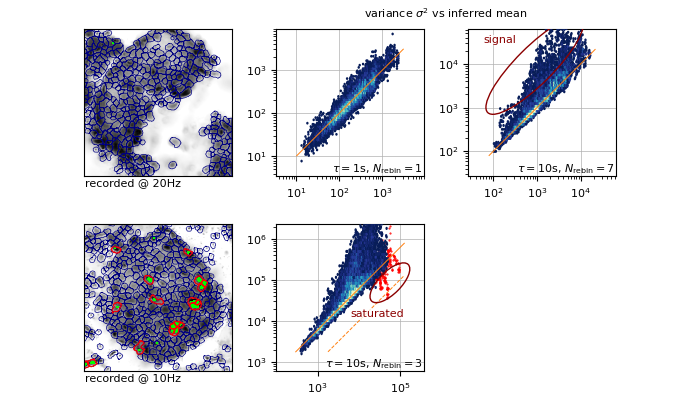

Nrebin=1

Nrebin=7

Nrebin=3



In [75]:
Npoints = 30
hexbincmap = "YlGnBu_r"
hexvmax = Npoints*1
# fig, axs = plt.subplots(2,4,figsize=np.array((7,4.5)), gridspec_kw=dict(width_ratios=[1,1,1,.07]))
figsize = np.array((7,4.))
ar = figsize[1]/figsize[0]
fig, axs = plt.subplots(2,3,figsize=figsize)
for ax in axs.flat:
    ax.set_aspect("equal")
alpha = .12
plt.subplots_adjust(top=1-alpha*ar, bottom=alpha*ar, right=1-alpha, left=alpha, wspace=.3, hspace=.3)
# plt.tight_layout()

for k,ax in zip(regions, [axs[0,0], axs[1,0]]):
    r = regions[k]
    im = r.statImages["mean"].copy()
    hp = r.statImages["highperc"].copy()
    vmin = np.percentile(im,10)
    im[hp==hp.max()] = np.nan
    ax.imshow(im, cmap=cmap, norm=LogNorm(vmin=vmin))
    ax.set_xticks([])
    ax.set_yticks([])
    r.plotEdges(ax=ax,image=False, lw=.5, scaleFontSize=0, color="navy")
    ax.text(.01,-.01,"recorded @ %.fHz"%r.Freq,va="top", transform=ax.transAxes)
r.df["Nsatur"] = [sum([np.isnan(im[px]) for px in pxs]) for pxs in r.df.pixels]
r.plotEdges(r.df.query("Nsatur>1").index, lw=.8, color="r",ax=ax, image=False, scaleFontSize=0)

axs[-1,-1].remove()
r = regions["photon counting mode"]
for ts,ax in zip([1,10],axs[0,1:3]):
    m,v = get_means_and_variances(r,ts,Npoints)
    pc = ax.hexbin(m,v,xscale="log", yscale="log", mincnt=1, cmap=hexbincmap, vmax=hexvmax,zorder=3)
    xl = ax.get_xlim()
    ax.set_xlim(xl[0]/3,xl[1]*3)
    ax.set_ylim(xl[0]/3,xl[1]*3)
    ax.plot(xl,xl,c="C1",lw=.7,zorder=5)
    filtPars = r.prep_filtering(ts,write=False)
    txt = r"$\tau = %g$s"%ts
    txt += ", "
    txt += r"$N_{\rm rebin} = %i$"%filtPars["Nrebin"]
    ax.text(.99,.03, txt, ha="right", transform=ax.transAxes,zorder=4)

    
ellipse = patches.Ellipse([.45,.75], .9, .25,
                          angle=45,
                          transform=ax.transAxes, fill=False,
                          edgecolor="darkred",
                          zorder=3
                         )
ax.add_patch(ellipse)
ax.text(.1,.9,"signal",
        transform=ax.transAxes,
        fontdict=dict(color="darkred"),
        zorder=4,
        bbox={"alpha":.8,"facecolor":"w","edgecolor":"none","pad":0}
       )

ax.text(-.15,1.07,r"variance $\sigma^2$ vs inferred mean ", transform=ax.transAxes,ha="center")
    
r = regions["standard mode"]
ax = axs[1,1]
m,v = get_means_and_variances(r,ts,Npoints)
ff = r.df.Nsatur<10
mrest, vrest = m[~ff], v[~ff]
m,v = m[ff], v[ff]
ax.plot(mrest.flat,vrest.flat,".", color="red", ms=1,zorder=3)
pc = ax.hexbin(m,v,xscale="log", yscale="log", mincnt=1, cmap=hexbincmap, vmax=hexvmax,zorder=4)

# hexax = fig.add_axes([.75,.03,.02,.4])
# hexax.set_ylim(0,)
# plt.colorbar(pc, cax=hexax)

xl = np.array(ax.get_xlim())
ax.set_xlim(xl[0]/3,xl[1]*3)
ax.set_ylim(xl[0]/3*r.gain,xl[1]*3*r.gain)
ax.plot(xl,xl*r.gain,c="C1",lw=.7,zorder=5)
ax.plot([xl[0]*r.gain,xl[1]],[xl[0]*r.gain,xl[1]],c="C1",ls="--",lw=.7,zorder=5)

filtPars = r.prep_filtering(ts,write=False)
txt = r"$\tau = %g$s"%ts
txt += ", "
txt += r"$N_{\rm rebin} = %i$"%filtPars["Nrebin"]
tb = ax.text(.99,.03, txt, ha="right", transform=ax.transAxes)

ellipse = patches.Ellipse([.77,.6], .35, .15, angle=45, transform=ax.transAxes, fill=False, edgecolor="darkred",zorder=10)
ax.add_patch(ellipse)
ax.text(.5,.37,"saturated",
        transform=ax.transAxes,
        fontdict=dict(color="darkred"),
        bbox={"alpha":.8,"facecolor":"w","edgecolor":"none","pad":0},
        zorder=10,
       )
for ax in [axs[0,2], axs[0,1], axs[1,1]]: ax.grid(lw=.5)
fig.savefig("figures/mean_vs_var.pdf")
fig.savefig("figures/mean_vs_var.png",dpi=300)

In [67]:
axs[0,2].grid()

In [63]:
ax.grid(lw=.5)

In [51]:
ellipse = patches.Ellipse([.45,.75], .9, .25,
                          angle=45,
                          transform=ax.transAxes, fill=False,
                          edgecolor="darkred",
                          zorder=10
                         )
ax.add_patch(ellipse)

### Backups

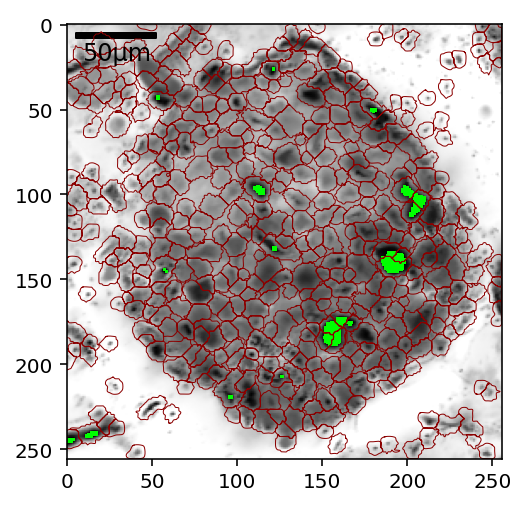

In [100]:
im = r.statImages["mean"].copy()
hp = r.statImages["highperc"].copy()
vmin = np.percentile(im,10)
im[hp==hp.max()] = np.nan
r.plotEdges(image=False)
plt.imshow(im, cmap=cmap, norm=LogNorm(vmin=vmin))


In [101]:
r.df["Nsatur"] = [sum([np.isnan(im[px]) for px in pxs]) for pxs in r.df.pixels]

Nrebin = 1
Nrebin=1



/opt/tljh/user/envs/physio_dev/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  
/opt/tljh/user/envs/physio_dev/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


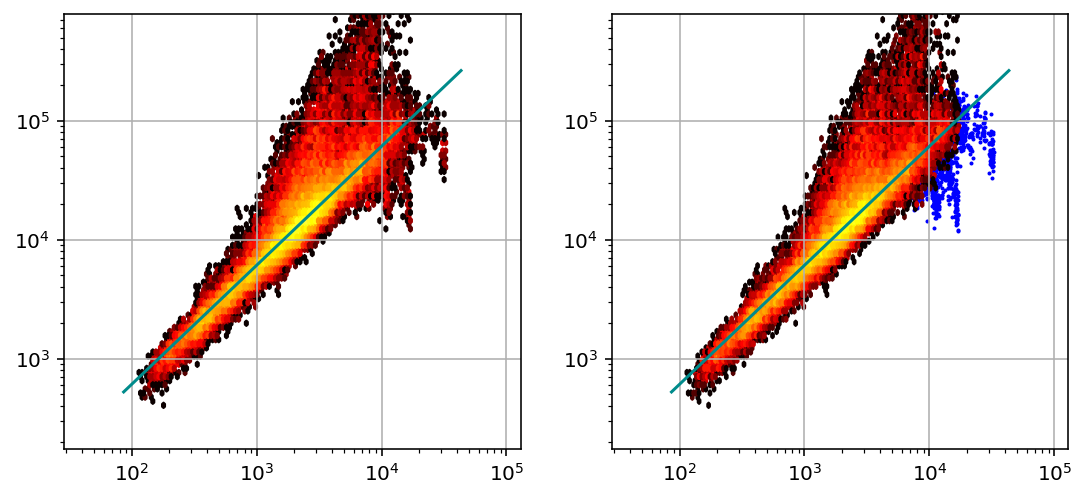

In [105]:
Npoints = 100
ts = 3
plt.figure(figsize=(9,4))
ax = plt.subplot(121)
m,v = get_means_and_variances(r,ts,Npoints)
ax.hexbin(m.flat,v.flat,xscale="log", bins='log', yscale="log", mincnt=1, cmap="hot", vmax=Npoints*5)
xl = np.array(ax.get_xlim())
ax.set_xlim(xl[0]/3,xl[1]*3)
ax.set_ylim(xl[0]/3*r.gain,xl[1]*3*r.gain)
ax.plot(xl,xl*r.gain,c="darkcyan")
ax.grid()

ax = plt.subplot(122)
ff = r.df.Nsatur<10
mrest, vrest = m[~ff], v[~ff]
m,v = m[ff], v[ff]
# ax.plot(mrest.flat, vrest.flat,"b.",ms=2, zorder=-1)
pc = ax.hexbin(m.flat,v.flat,xscale="log", bins='log', yscale="log", mincnt=1, cmap="viridis", vmax=Npoints*5)
pc = ax.hexbin(m.flat,v.flat,xscale="log", bins='log', yscale="log", mincnt=1, cmap="hot", vmax=Npoints*5)
ax.set_xlim(xl[0]/3,xl[1]*3)
ax.set_ylim(xl[0]/3*r.gain,xl[1]*3*r.gain)
ax.plot(xl,xl*r.gain,c="darkcyan")
ax.grid()

/opt/tljh/user/envs/physio_dev/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  


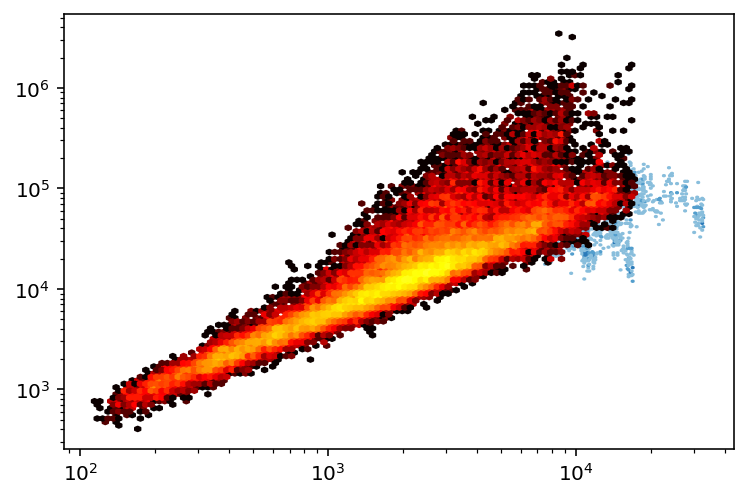

In [111]:
plt.hexbin(mrest.flat,vrest.flat,xscale="log", yscale="log", mincnt=1, cmap="Blues",vmin=-2)
plt.hexbin(m.flat,v.flat,xscale="log", bins='log', yscale="log", mincnt=1, cmap="hot", vmax=Npoints*5)

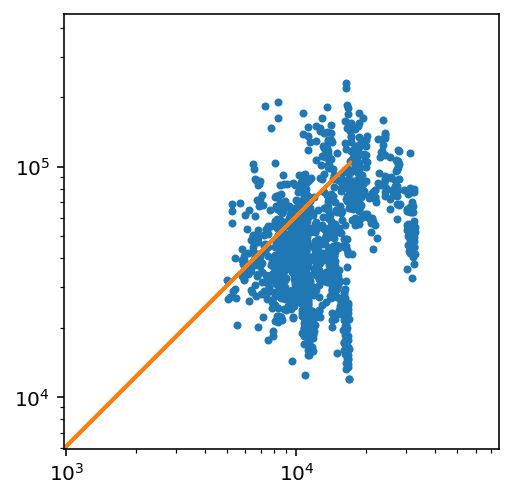

In [106]:
plt.plot(mrest.flat, vrest.flat,".")
plt.xscale("log")
plt.yscale("log")
plt.gca().set_aspect("equal")
plt.xlim(min(mrest.min(), vrest.min()/r.gain)/2, max(mrest.max(), vrest.max()/r.gain)*2)
plt.ylim(min(mrest.min()*r.gain, vrest.min())/2, max(mrest.max()*r.gain, vrest.max())*2)
plt.plot(m.flat, m.flatten()*r.gain)